In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
vocab_size = 256
x_ = list(map(ord, "hello"))
y_ = list(map(ord, "hola"))
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [3]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [5]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs, targets):
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        
        encoder_output = encoder_state = self.encoder(embedding, initial_state)
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [6]:
seq2seq = Seq2Seq(vocab_size, 16)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)


log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()

AttributeError: 'tuple' object has no attribute 'size'

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]

 반복:0 오차: 5.510807991027832
['\x84', 'ä', 'ä', 'ä']

 반복:100 오차: 1.977390170097351
['o', 'o', 'o', 'o']

 반복:200 오차: 0.8158316612243652
['h', 'o', 'l', 'a']

 반복:300 오차: 0.3874143362045288
['h', 'o', 'l', 'a']

 반복:400 오차: 0.20920610427856445
['h', 'o', 'l', 'a']

 반복:500 오차: 0.1351446807384491
['h', 'o', 'l', 'a']

 반복:600 오차: 0.09580101817846298
['h', 'o', 'l', 'a']

 반복:700 오차: 0.07147827744483948
['h', 'o', 'l', 'a']

 반복:800 오차: 0.055182408541440964
['h', 'o', 'l', 'a']

 반복:900 오차: 0.04383453354239464
['h', 'o', 'l', 'a']


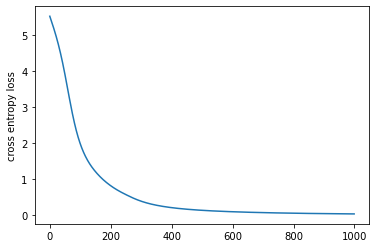

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt


vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)


x = torch.LongTensor(x_)
y = torch.LongTensor(y_)


class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()


seq2seq = Seq2Seq(vocab_size, 16)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)


log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()